# **Text classifier with TF-Hub**
Source of the tutorial: https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub

# Installations and Imports

In [1]:
# Install TF-Hub.
!pip install grpcio==1.26.0
!pip install -q tensorflow==2.1.0
!pip install -q tensorflow-hub
!pip install -q seaborn

In [0]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Data Downloading and Preparation

In [4]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(int(re.match("\d+_(\d+)\.txt", file_path).group(1)))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,Entertaining musical where Nathan Detroit need...,8,1
1,I am one of Jehovah's Witnesses and I also wor...,10,1
2,"In 1983, Director Brian De Palma set out to ma...",8,1
3,Very unnecessary movie with characters that ar...,2,0
4,I ordered this extremely rare and highly overr...,1,0


# Defining input functions for Estimators (Model)

### tf.compat.v1.estimator.inputs.pandas_input_fn
Returns input function that would feed Pandas DataFrame into the model and has a signature of "()->(dict of features, target)"

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)

# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

# Defining methods to extract Features for the model

### hub.text_embedding_column
Uses a Module to construct a dense representation from a text feature.


> **Note:** In case we need to use self trained embeddings or other third party embeddings like word2vec we can make a custom estimator and add the embeddings to the same



In [0]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

### feature_column.numeric_column
Represents real valued or numerical features

In [0]:
sentiment_feature_column = tf.feature_column.numeric_column("sentiment")

# Defining the estimator
DNNClassifier or in simple understandable terms an MLPclassifier.
Source: https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier

#### MLP (Excerpt from Wikipedia): 
A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). The term MLP is used ambiguously, sometimes loosely to refer to any feedforward ANN, sometimes strictly to refer to networks composed of multiple layers of perceptrons (with threshold activation); see § Terminology. Multilayer perceptrons are sometimes colloquially referred to as "vanilla" neural networks, especially when they have a single hidden layer.[1]

An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.[2][3] Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.[4]

#### Optimizer:
They tie together the loss function and model parameters by updating the model in response to the output of the loss function. In simpler terms, optimizers shape and mold your model into its most accurate possible form by futzing with the weights. The loss function is the guide to the terrain, telling the optimizer when it’s moving in the right or wrong direction. 



> ##### Adagrad Optimizer:
Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the updates


Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the updates

#### DNNClassifier argument definitions:
hidden_units: Iterable of number hidden units per layer. All layers are fully connected. Ex. [64, 32] means first layer has 64 nodes and second one has 32.
feature_columns: An iterable containing all the feature columns used by the model. All items in the set should be instances of classes derived from _FeatureColumn.
optimizer: An instance of tf.keras.optimizers.* used to train the model. Can also be a string (one of 'Adagrad', 'Adam', 'Ftrl', 'RMSProp', SGD'), or callable. Defaults to Adagrad optimizer.

In [12]:
# https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier#__init__
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column, sentiment_feature_column],
    n_classes=2,
    optimizer=tf.keras.optimizers.Adagrad(lr=0.003))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpyucrl265', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpyucrl265', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Training the model
Training for 5,000 steps means 640,000 training examples with the default batch size (128, defined in training input function). This is roughly equivalent to 25 epochs since the training dataset
contains 25,000 examples.

In [13]:
estimator.train(input_fn=train_input_fn, steps=5000);

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpyucrl265/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpyucrl265/model.ckpt.


INFO:tensorflow:loss = 0.73952127, step = 0


INFO:tensorflow:loss = 0.73952127, step = 0


INFO:tensorflow:global_step/sec: 58.4596


INFO:tensorflow:global_step/sec: 58.4596


INFO:tensorflow:loss = 0.2815117, step = 100 (1.717 sec)


INFO:tensorflow:loss = 0.2815117, step = 100 (1.717 sec)


INFO:tensorflow:global_step/sec: 62.0463


INFO:tensorflow:global_step/sec: 62.0463


INFO:tensorflow:loss = 0.18601018, step = 200 (1.607 sec)


INFO:tensorflow:loss = 0.18601018, step = 200 (1.607 sec)


INFO:tensorflow:global_step/sec: 61.4948


INFO:tensorflow:global_step/sec: 61.4948


INFO:tensorflow:loss = 0.13712648, step = 300 (1.630 sec)


INFO:tensorflow:loss = 0.13712648, step = 300 (1.630 sec)


INFO:tensorflow:global_step/sec: 61.903


INFO:tensorflow:global_step/sec: 61.903


INFO:tensorflow:loss = 0.13435546, step = 400 (1.612 sec)


INFO:tensorflow:loss = 0.13435546, step = 400 (1.612 sec)


INFO:tensorflow:global_step/sec: 60.742


INFO:tensorflow:global_step/sec: 60.742


INFO:tensorflow:loss = 0.116742685, step = 500 (1.650 sec)


INFO:tensorflow:loss = 0.116742685, step = 500 (1.650 sec)


INFO:tensorflow:global_step/sec: 61.0221


INFO:tensorflow:global_step/sec: 61.0221


INFO:tensorflow:loss = 0.106459305, step = 600 (1.639 sec)


INFO:tensorflow:loss = 0.106459305, step = 600 (1.639 sec)


INFO:tensorflow:global_step/sec: 60.497


INFO:tensorflow:global_step/sec: 60.497


INFO:tensorflow:loss = 0.08893095, step = 700 (1.653 sec)


INFO:tensorflow:loss = 0.08893095, step = 700 (1.653 sec)


INFO:tensorflow:global_step/sec: 58.822


INFO:tensorflow:global_step/sec: 58.822


INFO:tensorflow:loss = 0.12188393, step = 800 (1.697 sec)


INFO:tensorflow:loss = 0.12188393, step = 800 (1.697 sec)


INFO:tensorflow:global_step/sec: 59.3691


INFO:tensorflow:global_step/sec: 59.3691


INFO:tensorflow:loss = 0.10056937, step = 900 (1.683 sec)


INFO:tensorflow:loss = 0.10056937, step = 900 (1.683 sec)


INFO:tensorflow:global_step/sec: 59.2946


INFO:tensorflow:global_step/sec: 59.2946


INFO:tensorflow:loss = 0.103860825, step = 1000 (1.687 sec)


INFO:tensorflow:loss = 0.103860825, step = 1000 (1.687 sec)


INFO:tensorflow:global_step/sec: 60.2308


INFO:tensorflow:global_step/sec: 60.2308


INFO:tensorflow:loss = 0.07027616, step = 1100 (1.660 sec)


INFO:tensorflow:loss = 0.07027616, step = 1100 (1.660 sec)


INFO:tensorflow:global_step/sec: 58.6698


INFO:tensorflow:global_step/sec: 58.6698


INFO:tensorflow:loss = 0.11802396, step = 1200 (1.704 sec)


INFO:tensorflow:loss = 0.11802396, step = 1200 (1.704 sec)


INFO:tensorflow:global_step/sec: 61.1578


INFO:tensorflow:global_step/sec: 61.1578


INFO:tensorflow:loss = 0.04440014, step = 1300 (1.639 sec)


INFO:tensorflow:loss = 0.04440014, step = 1300 (1.639 sec)


INFO:tensorflow:global_step/sec: 61.9089


INFO:tensorflow:global_step/sec: 61.9089


INFO:tensorflow:loss = 0.09605495, step = 1400 (1.618 sec)


INFO:tensorflow:loss = 0.09605495, step = 1400 (1.618 sec)


INFO:tensorflow:global_step/sec: 60.0119


INFO:tensorflow:global_step/sec: 60.0119


INFO:tensorflow:loss = 0.07088562, step = 1500 (1.659 sec)


INFO:tensorflow:loss = 0.07088562, step = 1500 (1.659 sec)


INFO:tensorflow:global_step/sec: 60.2177


INFO:tensorflow:global_step/sec: 60.2177


INFO:tensorflow:loss = 0.050317883, step = 1600 (1.661 sec)


INFO:tensorflow:loss = 0.050317883, step = 1600 (1.661 sec)


INFO:tensorflow:global_step/sec: 59.769


INFO:tensorflow:global_step/sec: 59.769


INFO:tensorflow:loss = 0.040180936, step = 1700 (1.673 sec)


INFO:tensorflow:loss = 0.040180936, step = 1700 (1.673 sec)


INFO:tensorflow:global_step/sec: 60.5517


INFO:tensorflow:global_step/sec: 60.5517


INFO:tensorflow:loss = 0.0554049, step = 1800 (1.653 sec)


INFO:tensorflow:loss = 0.0554049, step = 1800 (1.653 sec)


INFO:tensorflow:global_step/sec: 60.4773


INFO:tensorflow:global_step/sec: 60.4773


INFO:tensorflow:loss = 0.048756342, step = 1900 (1.652 sec)


INFO:tensorflow:loss = 0.048756342, step = 1900 (1.652 sec)


INFO:tensorflow:global_step/sec: 56.375


INFO:tensorflow:global_step/sec: 56.375


INFO:tensorflow:loss = 0.066970475, step = 2000 (1.774 sec)


INFO:tensorflow:loss = 0.066970475, step = 2000 (1.774 sec)


INFO:tensorflow:global_step/sec: 60.7597


INFO:tensorflow:global_step/sec: 60.7597


INFO:tensorflow:loss = 0.036161065, step = 2100 (1.651 sec)


INFO:tensorflow:loss = 0.036161065, step = 2100 (1.651 sec)


INFO:tensorflow:global_step/sec: 58.9917


INFO:tensorflow:global_step/sec: 58.9917


INFO:tensorflow:loss = 0.056599483, step = 2200 (1.691 sec)


INFO:tensorflow:loss = 0.056599483, step = 2200 (1.691 sec)


INFO:tensorflow:global_step/sec: 59.3812


INFO:tensorflow:global_step/sec: 59.3812


INFO:tensorflow:loss = 0.040587198, step = 2300 (1.684 sec)


INFO:tensorflow:loss = 0.040587198, step = 2300 (1.684 sec)


INFO:tensorflow:global_step/sec: 60.4778


INFO:tensorflow:global_step/sec: 60.4778


INFO:tensorflow:loss = 0.03279424, step = 2400 (1.657 sec)


INFO:tensorflow:loss = 0.03279424, step = 2400 (1.657 sec)


INFO:tensorflow:global_step/sec: 59.2558


INFO:tensorflow:global_step/sec: 59.2558


INFO:tensorflow:loss = 0.037056293, step = 2500 (1.688 sec)


INFO:tensorflow:loss = 0.037056293, step = 2500 (1.688 sec)


INFO:tensorflow:global_step/sec: 61.6914


INFO:tensorflow:global_step/sec: 61.6914


INFO:tensorflow:loss = 0.036620118, step = 2600 (1.617 sec)


INFO:tensorflow:loss = 0.036620118, step = 2600 (1.617 sec)


INFO:tensorflow:global_step/sec: 59.4467


INFO:tensorflow:global_step/sec: 59.4467


INFO:tensorflow:loss = 0.037944913, step = 2700 (1.683 sec)


INFO:tensorflow:loss = 0.037944913, step = 2700 (1.683 sec)


INFO:tensorflow:global_step/sec: 58.0111


INFO:tensorflow:global_step/sec: 58.0111


INFO:tensorflow:loss = 0.018529119, step = 2800 (1.727 sec)


INFO:tensorflow:loss = 0.018529119, step = 2800 (1.727 sec)


INFO:tensorflow:global_step/sec: 59.331


INFO:tensorflow:global_step/sec: 59.331


INFO:tensorflow:loss = 0.019958075, step = 2900 (1.683 sec)


INFO:tensorflow:loss = 0.019958075, step = 2900 (1.683 sec)


INFO:tensorflow:global_step/sec: 59.0662


INFO:tensorflow:global_step/sec: 59.0662


INFO:tensorflow:loss = 0.025260573, step = 3000 (1.691 sec)


INFO:tensorflow:loss = 0.025260573, step = 3000 (1.691 sec)


INFO:tensorflow:global_step/sec: 60.7822


INFO:tensorflow:global_step/sec: 60.7822


INFO:tensorflow:loss = 0.026871227, step = 3100 (1.645 sec)


INFO:tensorflow:loss = 0.026871227, step = 3100 (1.645 sec)


INFO:tensorflow:global_step/sec: 58.0507


INFO:tensorflow:global_step/sec: 58.0507


INFO:tensorflow:loss = 0.054392453, step = 3200 (1.724 sec)


INFO:tensorflow:loss = 0.054392453, step = 3200 (1.724 sec)


INFO:tensorflow:global_step/sec: 53.6591


INFO:tensorflow:global_step/sec: 53.6591


INFO:tensorflow:loss = 0.028635435, step = 3300 (1.862 sec)


INFO:tensorflow:loss = 0.028635435, step = 3300 (1.862 sec)


INFO:tensorflow:global_step/sec: 57.787


INFO:tensorflow:global_step/sec: 57.787


INFO:tensorflow:loss = 0.030776406, step = 3400 (1.735 sec)


INFO:tensorflow:loss = 0.030776406, step = 3400 (1.735 sec)


INFO:tensorflow:global_step/sec: 58.8887


INFO:tensorflow:global_step/sec: 58.8887


INFO:tensorflow:loss = 0.026472319, step = 3500 (1.697 sec)


INFO:tensorflow:loss = 0.026472319, step = 3500 (1.697 sec)


INFO:tensorflow:global_step/sec: 58.5265


INFO:tensorflow:global_step/sec: 58.5265


INFO:tensorflow:loss = 0.016833687, step = 3600 (1.707 sec)


INFO:tensorflow:loss = 0.016833687, step = 3600 (1.707 sec)


INFO:tensorflow:global_step/sec: 57.7514


INFO:tensorflow:global_step/sec: 57.7514


INFO:tensorflow:loss = 0.03635436, step = 3700 (1.734 sec)


INFO:tensorflow:loss = 0.03635436, step = 3700 (1.734 sec)


INFO:tensorflow:global_step/sec: 58.6393


INFO:tensorflow:global_step/sec: 58.6393


INFO:tensorflow:loss = 0.027042938, step = 3800 (1.703 sec)


INFO:tensorflow:loss = 0.027042938, step = 3800 (1.703 sec)


INFO:tensorflow:global_step/sec: 61.5853


INFO:tensorflow:global_step/sec: 61.5853


INFO:tensorflow:loss = 0.02776796, step = 3900 (1.622 sec)


INFO:tensorflow:loss = 0.02776796, step = 3900 (1.622 sec)


INFO:tensorflow:global_step/sec: 61.5733


INFO:tensorflow:global_step/sec: 61.5733


INFO:tensorflow:loss = 0.016507788, step = 4000 (1.624 sec)


INFO:tensorflow:loss = 0.016507788, step = 4000 (1.624 sec)


INFO:tensorflow:global_step/sec: 60.7288


INFO:tensorflow:global_step/sec: 60.7288


INFO:tensorflow:loss = 0.020180732, step = 4100 (1.646 sec)


INFO:tensorflow:loss = 0.020180732, step = 4100 (1.646 sec)


INFO:tensorflow:global_step/sec: 60.4648


INFO:tensorflow:global_step/sec: 60.4648


INFO:tensorflow:loss = 0.011548594, step = 4200 (1.653 sec)


INFO:tensorflow:loss = 0.011548594, step = 4200 (1.653 sec)


INFO:tensorflow:global_step/sec: 60.1736


INFO:tensorflow:global_step/sec: 60.1736


INFO:tensorflow:loss = 0.018686283, step = 4300 (1.662 sec)


INFO:tensorflow:loss = 0.018686283, step = 4300 (1.662 sec)


INFO:tensorflow:global_step/sec: 58.9377


INFO:tensorflow:global_step/sec: 58.9377


INFO:tensorflow:loss = 0.016392212, step = 4400 (1.698 sec)


INFO:tensorflow:loss = 0.016392212, step = 4400 (1.698 sec)


INFO:tensorflow:global_step/sec: 59.7023


INFO:tensorflow:global_step/sec: 59.7023


INFO:tensorflow:loss = 0.024090819, step = 4500 (1.673 sec)


INFO:tensorflow:loss = 0.024090819, step = 4500 (1.673 sec)


INFO:tensorflow:global_step/sec: 60.2258


INFO:tensorflow:global_step/sec: 60.2258


INFO:tensorflow:loss = 0.017908797, step = 4600 (1.660 sec)


INFO:tensorflow:loss = 0.017908797, step = 4600 (1.660 sec)


INFO:tensorflow:global_step/sec: 57.287


INFO:tensorflow:global_step/sec: 57.287


INFO:tensorflow:loss = 0.0100369025, step = 4700 (1.749 sec)


INFO:tensorflow:loss = 0.0100369025, step = 4700 (1.749 sec)


INFO:tensorflow:global_step/sec: 60.1682


INFO:tensorflow:global_step/sec: 60.1682


INFO:tensorflow:loss = 0.03603856, step = 4800 (1.663 sec)


INFO:tensorflow:loss = 0.03603856, step = 4800 (1.663 sec)


INFO:tensorflow:global_step/sec: 61.0468


INFO:tensorflow:global_step/sec: 61.0468


INFO:tensorflow:loss = 0.014064954, step = 4900 (1.637 sec)


INFO:tensorflow:loss = 0.014064954, step = 4900 (1.637 sec)


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpyucrl265/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpyucrl265/model.ckpt.


INFO:tensorflow:Loss for final step: 0.014493849.


INFO:tensorflow:Loss for final step: 0.014493849.


# Evaluation
Evaluating model on the training and testing dataset

In [14]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-06T13:51:38Z


INFO:tensorflow:Starting evaluation at 2020-02-06T13:51:38Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.01845s


INFO:tensorflow:Inference Time : 5.01845s


INFO:tensorflow:Finished evaluation at 2020-02-06-13:51:43


INFO:tensorflow:Finished evaluation at 2020-02-06-13:51:43


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.99928, accuracy_baseline = 0.5, auc = 0.9999902, auc_precision_recall = 0.99999046, average_loss = 0.015253273, global_step = 5000, label/mean = 0.5, loss = 0.015245732, precision = 0.9997598, prediction/mean = 0.5039579, recall = 0.9988


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.99928, accuracy_baseline = 0.5, auc = 0.9999902, auc_precision_recall = 0.99999046, average_loss = 0.015253273, global_step = 5000, label/mean = 0.5, loss = 0.015245732, precision = 0.9997598, prediction/mean = 0.5039579, recall = 0.9988


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-06T13:51:44Z


INFO:tensorflow:Starting evaluation at 2020-02-06T13:51:44Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.91516s


INFO:tensorflow:Inference Time : 4.91516s


INFO:tensorflow:Finished evaluation at 2020-02-06-13:51:49


INFO:tensorflow:Finished evaluation at 2020-02-06-13:51:49


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9994, accuracy_baseline = 0.5, auc = 0.99999034, auc_precision_recall = 0.9999907, average_loss = 0.014487105, global_step = 5000, label/mean = 0.5, loss = 0.014484428, precision = 0.9996798, prediction/mean = 0.50490505, recall = 0.99912


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9994, accuracy_baseline = 0.5, auc = 0.99999034, auc_precision_recall = 0.9999907, average_loss = 0.014487105, global_step = 5000, label/mean = 0.5, loss = 0.014484428, precision = 0.9996798, prediction/mean = 0.50490505, recall = 0.99912


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpyucrl265/model.ckpt-5000


Training set accuracy: 0.9992799758911133
Test set accuracy: 0.9994000196456909


# Confusion Matrix

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


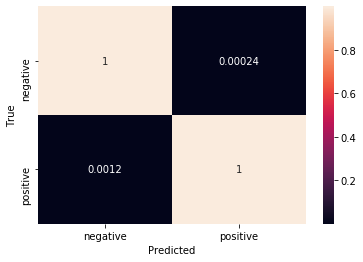

In [15]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
cm = tf.math.confusion_matrix(train_df["polarity"], 
                              get_predictions(estimator, predict_train_input_fn))

# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# Advanced: Transfer learning analysis
Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this part, we will demonstrate this by training with two different TF-Hub modules:


*   **nnlm-en-dim128**: pretrained text embedding module
*   **random-nnlm-en-dim128**: text embedding module that has same vocabulary and network as nnlm-en-dim128, but the weights were just randomly initialized and never trained on real data.

And by training in two modes:

* training only the classifier (i.e. freezing the module), and
* training the classifier together with the module.

In [0]:
def train_and_evaluate_with_module(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
      key="sentence", module_spec=hub_module, trainable=train_module)

  estimator = tf.estimator.DNNClassifier(
      hidden_units=[500, 100],
      feature_columns=[embedded_text_feature_column, sentiment_feature_column],
      n_classes=2,
      optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.003))

  estimator.train(input_fn=train_input_fn, steps=1000)

  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

  training_set_accuracy = train_eval_result["accuracy"]
  test_set_accuracy = test_eval_result["accuracy"]

  return {
      "Training accuracy": training_set_accuracy,
      "Test accuracy": test_set_accuracy
  }


results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

In [22]:
pd.DataFrame.from_dict(results, orient="index")

,Training accuracy,Test accuracy
nnlm-en-dim128,0.96996,0.97184
nnlm-en-dim128-with-module-training,0.97120,0.97288
random-nnlm-en-dim128,0.99260,0.99192
random-nnlm-en-dim128-with-module-training,0.99192,0.98976


# Baseline accuracy of the test set:
The lower bound that can be achieved by outputting only the label of the most represented class



> *Note: A baseline is the result of a very basic model/solution. You generally create a baseline and then try to make more complex solutions in order to get a better result. If you achieve a better score than the baseline, it is good.*



In [16]:
estimator.evaluate(input_fn=predict_test_input_fn)["accuracy_baseline"]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-06T14:22:28Z


INFO:tensorflow:Starting evaluation at 2020-02-06T14:22:28Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 4.89698s


INFO:tensorflow:Inference Time : 4.89698s


INFO:tensorflow:Finished evaluation at 2020-02-06-14:22:33


INFO:tensorflow:Finished evaluation at 2020-02-06-14:22:33


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9994, accuracy_baseline = 0.5, auc = 0.99999034, auc_precision_recall = 0.9999907, average_loss = 0.014487105, global_step = 5000, label/mean = 0.5, loss = 0.014484428, precision = 0.9996798, prediction/mean = 0.50490505, recall = 0.99912


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9994, accuracy_baseline = 0.5, auc = 0.99999034, auc_precision_recall = 0.9999907, average_loss = 0.014487105, global_step = 5000, label/mean = 0.5, loss = 0.014484428, precision = 0.9996798, prediction/mean = 0.50490505, recall = 0.99912


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpyucrl265/model.ckpt-5000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpyucrl265/model.ckpt-5000


0.5